# Model output (part 2)
-----
J. Potemra

April 2022

-----

In this notebook we will have a look at various model output.  These include forecast models run operationally (typically daily), reanalysis (run in "hindcast"), and climate models.

Last time looked at short-term (operational) wave forecast and compared to buoy (1) and did a difference in projected surface air temperature from a coupled climate model (2).

We will continue this investigation into model output.

## 3. Investigating model output: sea level 

In this example we will have a look at output from a coupled climate model and compare it to tide gauge data.  Recall that there are different types of IPCC model runs, and we will use the historical run to see about past (up to "present") and then different experiments to see about the future.

### Climate model output

The APDRC (http://apdrc.soest.hawaii.edu) hosts a variety of climate model output from the CMIP-5 set of experiments.  Here we will look at the output from the GFDL model, and compare the historical run with the RCP-8.5 experiment.

### 3A. Read in needed packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import netCDF4 as nc
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import datetime as dt

### 3B. Access data from the model

In [3]:
URL1 = 'http://apdrc.soest.hawaii.edu:80/dods/public_data/CMIP5/historical/zos/GFDL-CM3_r1i1p1_1'
zos_historical = nc.Dataset(URL1)

URL2 = 'http://apdrc.soest.hawaii.edu:80/dods/public_data/CMIP5/rcp85/zos/GFDL-CM3_r1i1p1_1'
zos_rcp85 = nc.Dataset(URL2)

### 3C. Extract lat/lon/time from model(s)

In [4]:
zos_historical

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format DAP2):
    title: CMIP5 Monthly historical ocean_gridded GFDL-CM3 r1i1p1 zos interpolated to 1-degree grid
    Conventions: COARDS
GrADS
    dataType: Grid
    documentation: http://apdrc.soest.hawaii.edu/datadoc/cmip5.php
    history: Fri Jan 28 10:59:17 HST 2022 : imported by GrADS Data Server 2.0
    dimensions(sizes): lat(180), lon(360), time(1752)
    variables(dimensions): float64 time(time), float64 lat(lat), float64 lon(lon), float32 zos(time, lat, lon)
    groups: 

In [5]:
lat_hist = zos_historical.variables['lat'][:] 
lon_hist = zos_historical.variables['lon'][:]
time_hist = zos_historical.variables['time'][:]

lat_rcp = zos_rcp85.variables['lat'][:] 
lon_rcp = zos_rcp85.variables['lon'][:]
time_rcp = zos_rcp85.variables['time'][:]

In [6]:
date_hist = pd.to_datetime(time_hist-time_hist[0], origin = '01-01-1860', unit='D')
date_rcp = pd.to_datetime(time_rcp-time_rcp[0], origin = '01-01-2006', unit='D')

In [8]:
date_rcp[0],date_rcp[-1]

(Timestamp('2006-01-01 00:00:00'), Timestamp('2100-12-01 00:00:00'))

### 3D. Find a single lat/lon point and extract output

In [9]:
# Here we pick a point to do our comparison
# Tuvalu (Western Pacific)
latitude = -8.525
longitude = 179.195
# Honolulu
#latitude = 20.0
#longitude = -158.0

J = np.argmin(np.abs( lat_hist - latitude ) )
I = np.argmin(np.abs( lon_hist - longitude ) )
print(J,I)

81 179


In [10]:
lat_hist[81],lon_hist[179]

(-8.5, 179.5)

In [11]:
zos_hist = zos_historical.variables['zos'][:,J,I]
zos_rcp = zos_rcp85.variables['zos'][:,J,I]

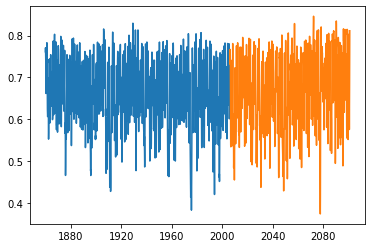

In [12]:
plt.plot(date_hist,zos_hist)
plt.plot(date_rcp,zos_rcp);

### 3E. Fit with running mean (_i.e._, smoothing the data)

The raw data plot in this case is somewhat noisy since we are plotting monthly means over long (200 year) record.  We saw this with the tide gauge data as well, only in that case it was hourly data plotted over several years.  In that case, we performed a monthly mean to smooth out the data.  Now, we will do a __running mean__ or __moving average__ to smooth out the data.  The basic idea is to compute the mean over a certain interval, or window, then slide this window progressively throught the data.

In mathematical terms, if we have a variable, $sl$ (_e.g._, sea level), measured at times $i$, for $N$ number of times, the mean ($\langle sl \rangle$) can be represented as:

\begin{eqnarray}
   \langle sl \rangle = \frac{1}{N} \sum_{i=1}^{i=N} sl_{i}
\end{eqnarray}

For a running mean, we compute the mean over an equal number of data points on either side of a central value.  For example, the mean over a interval of $n$ points where each value is $sl(k)$ would be taken from $n-k+2$ to $n+1$.  The _next_ mean would then be computing using the _prev_ one:

<math>
\begin{align}
   \langle sl \rangle_{k, next} &= \frac{1}{k} \sum_{i=n-k+2}^{n+1} sl_{i}  \\
              &= \frac{1}{k} \Big( \underbrace{ sl_{n-k+2} + sl_{n-k+3} + \dots + sl_{n} + sl_{n+1} }_{ \sum_{i=n-k+2}^{n+1} sl_{i} } + \underbrace{ sl_{n-k+1} - sl_{n-k+1} }_{= 0} \Big)  \\
              &= \underbrace{ \frac{1}{k} \Big( sl_{n-k+1} + sl_{n-k+2} + \dots + sl_{n} \Big) }_{= \langle sl \rangle_{k, prev}} - \frac{sl_{n-k+1}}{k} + \frac{sl_{n+1}}{k}  \\
              &= \langle sl \rangle_{k, prev} + \frac{1}{k} \Big( sl_{n+1} - sl_{n-k+1} \Big)
\end{align}
</math>


As it turns out, as easy way to do this is via __covolution__.  Here, we convolve the original time-series ($sl$) with a signal that is a window of a specific length $w$ (aka, a _box car_).  The discrete convolution operation is defined as

\begin{eqnarray}
(sl * w)_{n} = \sum_{m = -n}^{n} sl_{m} w_{n-m}
\end{eqnarray}

Finally, numpy has a function called "convolve" that will do all the work for us!

In [13]:
# Define our own function that convolves the original data
#  (rawdata) and a boxcar of a specific width (window_size)
def movingaverage(rawdata, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve( rawdata, window, 'valid' )

In [16]:
zos_hist_filt = movingaverage(zos_hist,60)
zos_rcp_filt = movingaverage(zos_rcp,60)

# Note we need to "pad" the output with NaN's since
#  the running average will be missing some points
zos_hist_filt = np.append(zos_hist_filt,[np.nan]*59)
zos_rcp_filt = np.append(zos_rcp_filt,[np.nan]*59)

In [17]:
len(zos_hist_filt),len(zos_hist)

(1752, 1752)

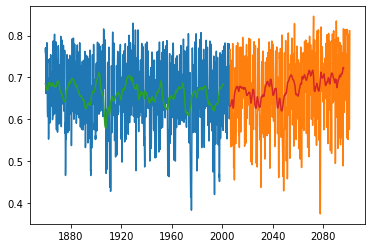

In [18]:
plt.plot(date_hist,zos_hist)
plt.plot(date_rcp,zos_rcp)
plt.plot(date_hist,zos_hist_filt)
plt.plot(date_rcp,zos_rcp_filt)

### 3F. Access data from the tide gauge

In [19]:
import pandas as pd
tideg = pd.read_csv("http://uhslc.soest.hawaii.edu/data/csv/fast/hourly/h025.csv", header=None)

In [20]:
sl_tide = tideg[4]
date = pd.to_datetime(tideg.index*3600.0, origin = '03-24-1993', unit='s')

In [21]:
sl_tide[sl_tide < 0] = np.nan

(9131.0, 13148.0)

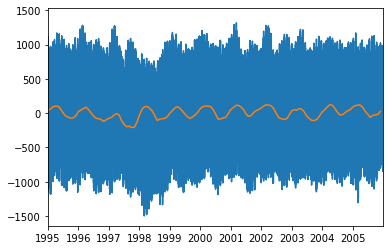

In [22]:
plt.plot(date,sl_tide-sl_tide.mean())
plt.plot(date_hist,1000*(zos_hist-zos_hist.mean()))
plt.xlim([dt.datetime(1995, 1, 1), dt.datetime(2005, 12, 31)])

(9131.0, 13148.0)

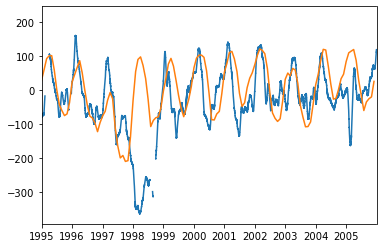

In [23]:
# function "movingaverage" needs an input time-series and window width
# here the width is 24*30
sl2_tide = movingaverage(sl_tide,24*30)
sl2_tide = np.append(sl2_tide,[np.nan]*(24*30-1))

plt.plot(date,sl2_tide-sl_tide.mean())
plt.plot(date_hist,1000*(zos_hist-zos_hist.mean()))
plt.xlim([dt.datetime(1995, 1, 1), dt.datetime(2005, 12, 31)])

## 4. Analysis of numerical model output: ENSO variability

We've talked about the El Nino/Southern Oscillation (ENSO) in previous classes; it is the dominant mode of interannual variability in the tropical Pacific.  El Nino's (aka warm events) occur roughly every 2 to 5 years, peak in NH winter, and are characterized by anomalously warm sea surface temperatures (SST) in the eastern Pacific and anomalously cold SST in the western equatorial Pacific.  

There are various ways to quantify ENSO events, and most are based on some regional average of SST. 
<img src='../images/nino-regions.gif'>

The NINO-3.4 index, for example, is the mean SST anomalies in a box in the eastern tropical Pacific.  A positive NINO-3 then indicates an El Nino event; cold/negative NINO-3.4 indicates a La Nina.  
<img src='../images/elnino-f-pg.gif'>

In this notebook we will try to compute our own ENSO index from model-derived SST's. We can have a look at things like ENSO variability in future climate.  The first step will be to construct our index:

 1. copmute mean over a lat/lon box
 2. compute and remove the mean seasonal cycle
 3. smooth with 3-month running mean filter
 4. identify warm events and plot

For reference, https://www.ncdc.noaa.gov/teleconnections/enso/indicators/sst/ shows the NOAA version.

### 4A. Load needed packages

In [24]:
import numpy as np
import pandas as pd

import xarray as xr
import netCDF4 as nc

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.ticker as mticker

import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import datetime as dt

### 4B. Read data

In [25]:
# read data from APDRC URL
URL = 'http://apdrc.soest.hawaii.edu:80/dods/public_data/CMIP5/historical/tos/GFDL-CM3_r1i1p1_1'
dataset = nc.Dataset(URL)

In [26]:
# extract time, lat, lon
time = dataset.variables['time'][:]
lat = dataset.variables['lat'][:]
lon = dataset.variables['lon'][:]

In [27]:
# convert time to datetime
date = pd.to_datetime(time-time[0], origin = '01-01-1860', unit='D')

In [28]:
# extract SST for NINO-3.4 region (Eastern equatorial Pacific)
J = np.argwhere( (lat >= -5) & (lat <= 5) )
I = np.argwhere( (lon >= 190) & (lon <= 240) )
SST = dataset.variables['tos'][:,int(J[0]):int(J[-1]),int(I[0]):int(I[-1])]

In [31]:
I

array([[190],
       [191],
       [192],
       [193],
       [194],
       [195],
       [196],
       [197],
       [198],
       [199],
       [200],
       [201],
       [202],
       [203],
       [204],
       [205],
       [206],
       [207],
       [208],
       [209],
       [210],
       [211],
       [212],
       [213],
       [214],
       [215],
       [216],
       [217],
       [218],
       [219],
       [220],
       [221],
       [222],
       [223],
       [224],
       [225],
       [226],
       [227],
       [228],
       [229],
       [230],
       [231],
       [232],
       [233],
       [234],
       [235],
       [236],
       [237],
       [238],
       [239]])

In [33]:
A = SST.mean()

In [34]:
A

299.011

In [35]:
# compute mean over NINO-3.4 region
# note: axis=(1,2) means compute the average over
# the second two dimensions only (lat, lon); not time
SST_ave = SST.mean(axis=(1,2))

In [36]:
# compute seasonal anomalies
#  1. make DataFrame
df = pd.DataFrame(SST_ave,date)
df.columns = ['SST']
df.head()

SST
1860-01-01  298.585022
1860-02-01  298.368591
1860-03-01  298.488770
1860-04-01  298.944031
1860-05-01  299.536255

In [37]:
#  2. compute climatology
mean_season = df.groupby(df.index.month).mean()
#  3. convert 12-monthly means to continuous time
step1 = mean_season.squeeze()
step2 = np.tile(step1,len(df)//len(mean_season))
#  4. add to DataFrame
df['clim'] = step2

In [39]:
df.head(24)

SST        clim
1860-01-01  298.585022  299.372681
1860-02-01  298.368591  299.135193
1860-03-01  298.488770  298.845581
1860-04-01  298.944031  298.825592
1860-05-01  299.536255  299.255157
1860-06-01  299.802338  299.320496
1860-07-01  299.688965  299.061554
1860-08-01  299.115509  298.717072
1860-09-01  298.636536  298.496033
1860-10-01  298.796417  298.654449
1860-11-01  299.192963  299.089661
1860-12-01  299.413269  299.358673
1861-01-01  299.447266  299.372681
1861-02-01  299.105469  299.135193
1861-03-01  298.731720  298.845581
1861-04-01  298.739716  298.825592
1861-05-01  299.446930  299.255157
1861-06-01  299.642090  299.320496
1861-07-01  299.529327  299.061554
1861-08-01  298.992279  298.717072
1861-09-01  298.975220  298.496033
1861-10-01  299.621002  298.654449
1861-11-01  300.203217  299.089661
1861-12-01  300.698273  299.358673

In [41]:
nino34 = movingaverage((df['SST']-df['clim']),3)
nino34 = np.append(nino34,[np.nan]*2)
df['NINO3'] = nino34

In [42]:
df.head()

SST        clim     NINO3
1860-01-01  298.585022  299.372681 -0.637024
1860-02-01  298.368591  299.135193 -0.334991
1860-03-01  298.488770  298.845581  0.014242
1860-04-01  298.944031  298.825592  0.293793
1860-05-01  299.536255  299.255157  0.463450

### 4C. Make a plot of NINO-index

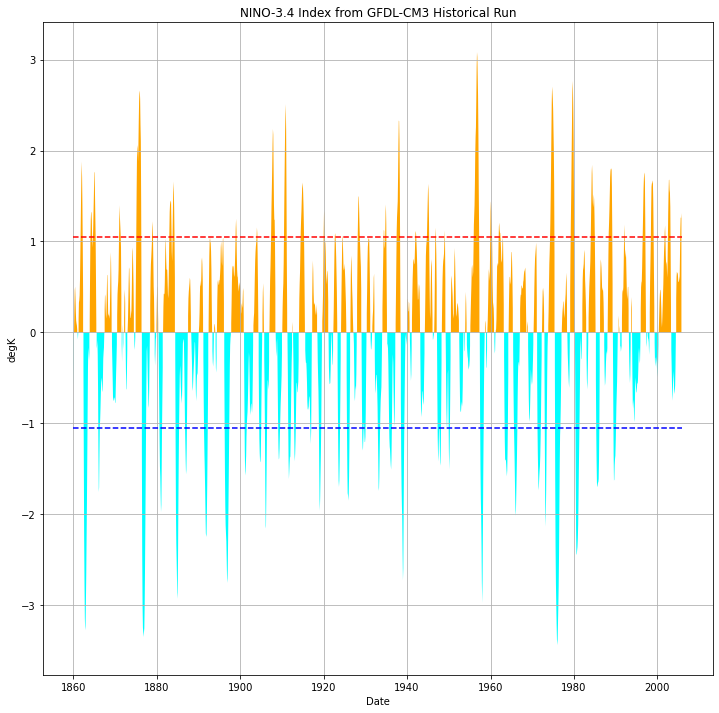

In [43]:
fig = plt.figure(figsize=(12,12))
plt.fill_between(date,0,df['NINO3'],where=df['NINO3']>=0,facecolor='orange')
plt.fill_between(date,0,df['NINO3'],where=df['NINO3']<0,facecolor='cyan')
plt.grid()
plt.xlabel('Date')
plt.ylabel('degK')
plt.title('NINO-3.4 Index from GFDL-CM3 Historical Run')

plt.plot([date[0],date[-1]],[df['NINO3'].std(),df['NINO3'].std()],'r--')
plt.plot([date[0],date[-1]],[-df['NINO3'].std(),-df['NINO3'].std()],'b--');

### 4D. Compare ENSO events from different RCP's

We can make use of a "for loop" to cycle through three difference experiments: historical, RCP-4.5 and RCP-8.5.  For each, we compute the NINO-3 index like before, then print some simple statistics.

In [44]:
URL = ['http://apdrc.soest.hawaii.edu:80/dods/public_data/CMIP5/historical/tos/GFDL-CM3_r1i1p1_1']
URL = np.append(URL,'http://apdrc.soest.hawaii.edu:80/dods/public_data/CMIP5/rcp45/tos/GFDL-CM3_r1i1p1_1')
URL = np.append(URL,'http://apdrc.soest.hawaii.edu:80/dods/public_data/CMIP5/rcp85/tos/GFDL-CM3_r1i1p1_1')
#first_time = np.array([u'01-01-1860', u'01-01-2006', u'01-01-2006'], dtype=object)
first_time = np.array([u'01-01-1860', u'01-01-1700', u'01-01-1700'], dtype=object)
for model in range(3):
    dataset = nc.Dataset(URL[model])
    print('reading ', URL[model])
    time = dataset.variables['time'][:]
    lat = dataset.variables['lat'][:]
    lon = dataset.variables['lon'][:]
    date = pd.to_datetime(time-time[0], origin = first_time[model], unit='D')
    J = np.argwhere( (lat >= -5) & (lat <= 5) )
    I = np.argwhere( (lon >= 190) & (lon <= 240) )
    SST = dataset.variables['tos'][:,int(J[0]):int(J[-1]),int(I[0]):int(I[-1])]
    SST_ave = SST.mean(axis=(1,2))
    df = pd.DataFrame(SST_ave,date)
    df.columns = ['SST']
    mean_season = df.groupby(df.index.month).mean()
    step1 = mean_season.squeeze()
    step2 = np.tile(step1,len(df)//len(mean_season))
    df['clim'] = step2
    nino3 = movingaverage((df['SST']-df['clim']),3)
    nino3 = np.append(nino3,[np.nan]*2)
    df['NINO3'] = nino3
    if model == 0:
        nino_historical = df
    elif model == 1:
        nino_rcp45 = df
    elif model == 2:
        nino_rcp85 = df
    dataset.close()

reading  http://apdrc.soest.hawaii.edu:80/dods/public_data/CMIP5/historical/tos/GFDL-CM3_r1i1p1_1
reading  http://apdrc.soest.hawaii.edu:80/dods/public_data/CMIP5/rcp45/tos/GFDL-CM3_r1i1p1_1
reading  http://apdrc.soest.hawaii.edu:80/dods/public_data/CMIP5/rcp85/tos/GFDL-CM3_r1i1p1_1


### 4E. Print the total number of warm events and the date of the maximum ones

In [45]:
# First we look for the number of warm events.  To do this, we
#  count the number of times the NINO-3 index exceeds a certain
#  value (2.5) for December.  These are somewhat arbitrary values;
#  December is usually the peak of the El Nino event, and 0.5 is
#  the minimum, so here we try 3 times that to identify extreme
#  events.

threshold = 2.5
max_month = 12

ElNino = (nino_historical.index.month == max_month) & (nino_historical['NINO3'] > threshold )
warm_events = ElNino.sum()
max_event = nino_historical['NINO3'].argmax()
time_max = nino_historical.index[max_event]
print('Historical run')
print('  number of warm events: ', warm_events)
print('      max warm event on: ', time_max, 'index=', max_event)

ElNino = (nino_rcp45.index.month == max_month) & (nino_rcp45['NINO3'] > threshold )
warm_events = ElNino.sum()
max_event = nino_rcp45['NINO3'].argmax()
time_max = nino_rcp45.index[max_event]
print('RCP-4.5 run')
print('  number of warm events: ', warm_events)
print('      max warm event on: ', time_max, 'index=', max_event)

ElNino = (nino_rcp85.index.month == max_month) & (nino_rcp85['NINO3'] > threshold )
warm_events = ElNino.sum()
max_event = nino_rcp85['NINO3'].argmax()
time_max = nino_rcp85.index[max_event]
print('RCP-8.5 run')
print('  number of warm events: ', warm_events)
print('      max warm event on: ', time_max, 'index=', max_event)

Historical run
  number of warm events:  4
      max warm event on:  1956-10-01 00:00:00 index= 1161
RCP-4.5 run
  number of warm events:  3
      max warm event on:  1875-10-02 00:00:00 index= 2109
RCP-8.5 run
  number of warm events:  8
      max warm event on:  1779-08-02 00:00:00 index= 955


### 4F. Plot these max events

reading  http://apdrc.soest.hawaii.edu:80/dods/public_data/CMIP5/historical/tos/GFDL-CM3_r1i1p1_1
reading  http://apdrc.soest.hawaii.edu:80/dods/public_data/CMIP5/rcp45/tos/GFDL-CM3_r1i1p1_1
reading  http://apdrc.soest.hawaii.edu:80/dods/public_data/CMIP5/rcp85/tos/GFDL-CM3_r1i1p1_1


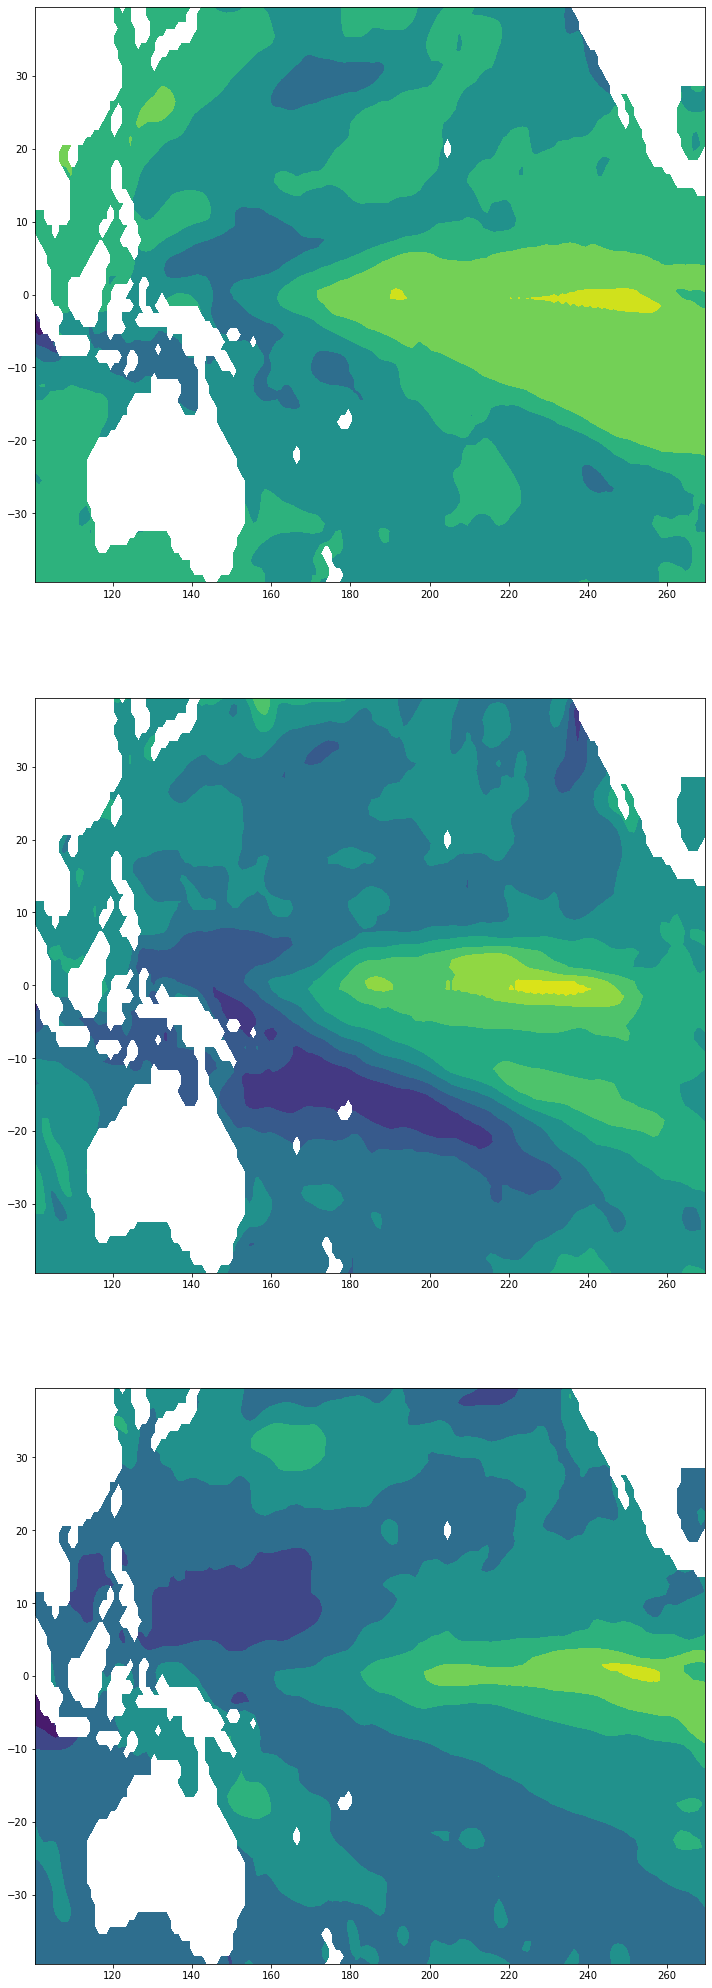

In [46]:
plt.figure(figsize=(12,36))
max_time = [1161,2109,955]
for model in range(3):
    dataset = nc.Dataset(URL[model])
    print('reading ', URL[model])
    time = dataset.variables['time'][:]
    lat = dataset.variables['lat'][:]
    lon = dataset.variables['lon'][:]
    J = np.argwhere( (lat >= -40) & (lat <= 40) )
    I = np.argwhere( (lon >= 100) & (lon <= 270) )
    SST1 = dataset.variables['tos'][max_time[model],int(J[0]):int(J[-1])+1,int(I[0]):int(I[-1])+1]
    SSTdiff = SST1 - dataset.variables['tos'][max_time[model]-12,int(J[0]):int(J[-1])+1,int(I[0]):int(I[-1])+1]
    ax = plt.subplot(3,1,model+1)
    plt.contourf(lon[I].squeeze(),lat[J].squeeze(),SSTdiff)

### 4G. Redo with xarray

In [29]:
URL = 'http://apdrc.soest.hawaii.edu:80/dods/public_data/CMIP5/historical/tos/GFDL-CM3_r1i1p1_1'
dataset = xr.open_dataset(URL)

/opt/tljh/user/lib/python3.9/site-packages/xarray/coding/times.py:123: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:0.0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:0.0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


In [30]:
SSTbox = dataset['tos'].sel(lat=slice(-5.0,5.0), 
             lon=slice(200, 280)).mean(dim=['lat', 'lon'])

In [31]:
groupby_op = 'time.month'
clim = SSTbox.sel(time=slice('1981-01-01', '2010-12-31')).groupby(groupby_op).mean()
anom = SSTbox.groupby(groupby_op) - clim

Text(0.5, 1.0, 'NINO-3 Index from GFDL-CM3 Historical Run')

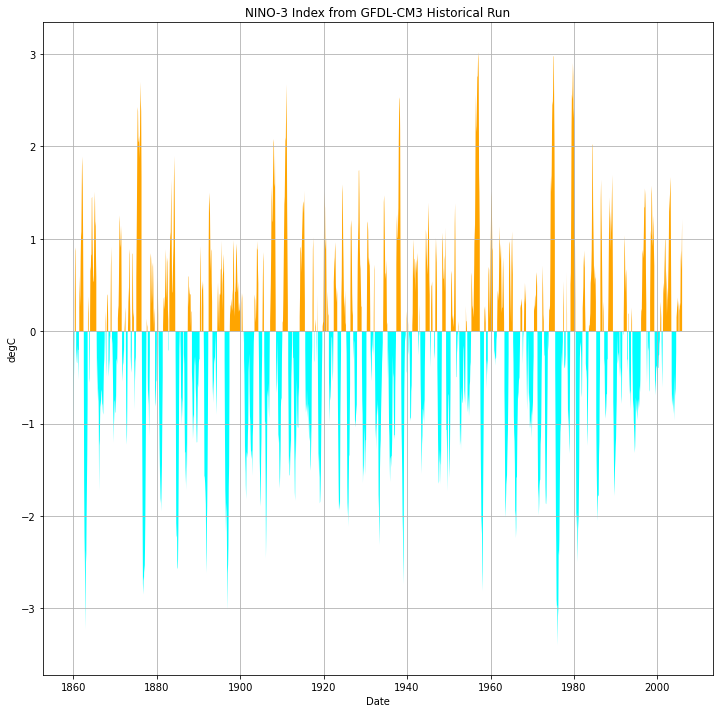

In [32]:
fig = plt.figure(figsize=(12,12))
jtime = pd.to_datetime(dataset['time'])
plt.fill_between(jtime,0,anom,where=anom>=0,facecolor='orange')
plt.fill_between(jtime,0,anom,where=anom<0,facecolor='cyan')
plt.grid()
plt.xlabel('Date')
plt.ylabel('degC')
plt.title('NINO-3 Index from GFDL-CM3 Historical Run')